# Atelier pratique : Analyse de logs de sécurité

## Introduction
Dans cet atelier, nous allons explorer un jeu de données de logs de sécurité pour apprendre à :
- Manipuler des données de logs avec Python et pandas
- Détecter des patterns suspects
- Visualiser des données de sécurité

## 1. Configuration de l'environnement

In [13]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de l'affichage
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', None)

## 2. Chargement et préparation des données

Notre jeu de données contient des logs d'authentification SSH avec les colonnes suivantes :
- timestamp : Date et heure de la tentative
- ip_source : Adresse IP source
- username : Nom d'utilisateur utilisé
- success : Succès (1) ou échec (0) de la connexion
- port : Port utilisé

In [2]:
# Création d'un dataset exemple
data = {
    'timestamp': pd.date_range(start='2024-01-01', periods=1000, freq='5T'),
    'ip_source': np.random.choice(['192.168.1.' + str(i) for i in range(1,20)] + 
                               ['10.0.0.' + str(i) for i in range(1,10)], 1000),
    'username': np.random.choice(['admin', 'root', 'user', 'test', 'oracle'], 1000),
    'success': np.random.choice([0, 1], 1000, p=[0.8, 0.2]),  # 20% de succès
    'port': np.random.choice([22, 2222, 22222], 1000, p=[0.7, 0.2, 0.1])
}

df = pd.DataFrame(data)

# Affichage des premières lignes
print("Aperçu des données :")
df.head()

Aperçu des données :


,timestamp,ip_source,username,success,port
0,2024-01-01 00:00:00,10.0.0.2,user,0,22
1,2024-01-01 00:05:00,192.168.1.3,test,0,22
2,2024-01-01 00:10:00,192.168.1.1,user,1,22
3,2024-01-01 00:15:00,192.168.1.13,user,0,22
4,2024-01-01 00:20:00,192.168.1.15,root,0,22


## 3. Exploration initiale des données
Commençons par examiner la structure et les statistiques de base de notre dataset.

In [4]:
# Informations générales sur le dataset
print("Informations sur le dataset :")
df.info()

print("\nStatistiques descriptives :")
df.describe(include='all')

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1000 non-null   datetime64[ns]
 1   ip_source  1000 non-null   object        
 2   username   1000 non-null   object        
 3   success    1000 non-null   int64         
 4   port       1000 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 39.2+ KB

Statistiques descriptives :


,timestamp,ip_source,username,success,port
count,1000,1000,1000,1000.00000,1000.000000
unique,1000,28,5,NaN,NaN
top,2024-01-03 00:50:00,10.0.0.5,admin,NaN,NaN
freq,1,49,220,NaN,NaN
first,2024-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2024-01-04 11:15:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.19200,2495.400000
std,NaN,NaN,NaN,0.39407,6306.150964
min,NaN,NaN,NaN,0.00000,22.000000
25%,NaN,NaN,NaN,0.00000,22.000000


## 4. Analyse des tentatives de connexion
Analysons maintenant les patterns de connexion par utilisateur.

Statistiques par utilisateur :
          total_attempts  successful_attempts  success_rate
username                                                   
admin                220                   37         0.168
test                 206                   43         0.209
oracle               202                   35         0.173
user                 189                   36         0.190
root                 183                   41         0.224


<Figure size 720x432 with 0 Axes>

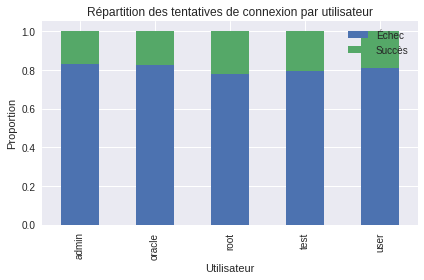

In [5]:
# Analyse des tentatives par utilisateur
user_stats = df.groupby('username').agg({
    'success': ['count', 'sum', 'mean']
}).round(3)

user_stats.columns = ['total_attempts', 'successful_attempts', 'success_rate']
print("Statistiques par utilisateur :")
print(user_stats.sort_values('total_attempts', ascending=False))

# Visualisation des tentatives par utilisateur
plt.figure(figsize=(10, 6))
user_attempts = df.groupby('username')['success'].value_counts(normalize=True).unstack()
user_attempts.plot(kind='bar', stacked=True)
plt.title('Répartition des tentatives de connexion par utilisateur')
plt.xlabel('Utilisateur')
plt.ylabel('Proportion')
plt.legend(['Échec', 'Succès'])
plt.tight_layout()
plt.show()

## 5. Détection d'activités suspectes
Identifions les comportements potentiellement malveillants dans nos logs.

Top 10 des IP sources avec le plus d'échecs :
ip_source
192.168.1.13    41
10.0.0.5        40
10.0.0.8        38
192.168.1.10    36
192.168.1.9     36
192.168.1.8     35
192.168.1.16    34
192.168.1.11    33
192.168.1.15    33
192.168.1.17    32
dtype: int64


<Figure size 864x432 with 0 Axes>

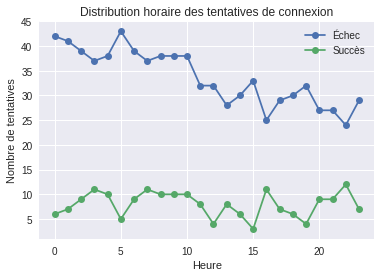

In [6]:
# Identification des IP sources avec beaucoup d'échecs
suspicious_ips = df[df['success'] == 0].groupby('ip_source').size()\
                 .sort_values(ascending=False).head(10)

print("Top 10 des IP sources avec le plus d'échecs :")
print(suspicious_ips)

# Visualisation des tentatives suspectes dans le temps
df['hour'] = df['timestamp'].dt.hour
hourly_attempts = df.groupby(['hour', 'success']).size().unstack()

plt.figure(figsize=(12, 6))
hourly_attempts.plot(kind='line', marker='o')
plt.title('Distribution horaire des tentatives de connexion')
plt.xlabel('Heure')
plt.ylabel('Nombre de tentatives')
plt.legend(['Échec', 'Succès'])
plt.grid(True)
plt.show()

## 6. Exercices pratiques

À vous de jouer ! Utilisez les données et techniques vues précédemment pour réaliser les analyses suivantes :

1. Calculez le taux d'échec par port et identifiez si certains ports sont plus ciblés
2. Créez une visualisation montrant la distribution des tentatives par IP source
3. Identifiez les patterns temporels suspects (ex: rafales de tentatives)
4. Proposez des indicateurs pour détecter une attaque par force brute

Conseils :
- Utilisez les fonctions groupby(), agg() pour les agrégations
- Pensez à utiliser les fonctions de visualisation (plot(), bar(), etc.)
- N'hésitez pas à créer de nouvelles colonnes pour faciliter l'analyse

In [20]:
# Création de données plus réalistes avec des pics d'activité
np.random.seed(42)  # Pour la reproductibilité

# Création d'une liste pour stocker tous les timestamps
timestamps = []

# Générer environ 1000 événements avec des pics d'activité
base_timestamps = pd.date_range(start='2024-01-01', periods=200, freq='30T')

for base_time in base_timestamps:
    if np.random.random() < 0.2:  # 20% de chance d'avoir un pic d'activité
        # Ajouter plusieurs événements dans un court intervalle
        n_cluster = np.random.randint(3, 10)
        for _ in range(n_cluster):
            timestamps.append(base_time + pd.Timedelta(seconds=np.random.randint(0, 300)))
    else:
        # Ajouter un seul événement
        timestamps.append(base_time)

# S'assurer que nous avons le bon nombre d'événements
n_events = len(timestamps)

# Création du DataFrame avec des listes de même longueur
data = {
    'timestamp': sorted(timestamps),
    'ip_source': np.random.choice(['192.168.1.' + str(i) for i in range(1,20)] + 
                               ['10.0.0.' + str(i) for i in range(1,10)], n_events),
    'username': np.random.choice(['admin', 'root', 'user', 'test', 'oracle'], n_events),
    'success': np.random.choice([0, 1], n_events, p=[0.8, 0.2]),
    'port': np.random.choice([22, 2222, 22222], n_events, p=[0.7, 0.2, 0.1])
}

df = pd.DataFrame(data)

## Solution 1 : Analyse des taux d'échec par port

Pour analyser les taux d'échec par port, nous allons :
1. Grouper les données par port
2. Calculer le nombre total de tentatives et le nombre d'échecs
3. Calculer le taux d'échec
4. Visualiser les résultats

Statistiques par port :
       total_tentatives  echecs  taux_echec
port                                       
22                  290     225       77.59
2222                 66      52       78.79
22222                30      24       80.00


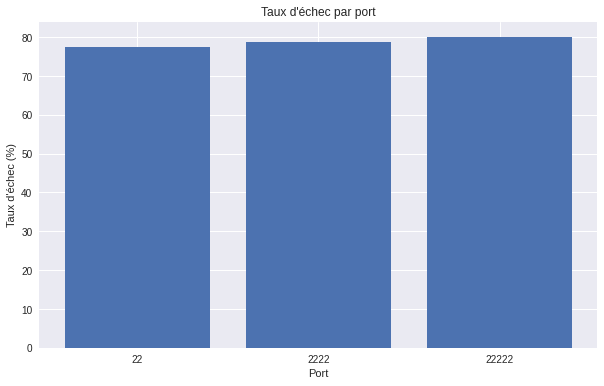


Le port le plus ciblé est le port 22


In [17]:
# Calcul des statistiques par port
port_stats = df.groupby('port').agg({
    'success': [
        ('total_tentatives', 'count'),
        ('echecs', lambda x: (x == 0).sum()),
        ('taux_echec', lambda x: (x == 0).mean() * 100)
    ]
}).round(2)

# Simplification des noms de colonnes
port_stats.columns = ['total_tentatives', 'echecs', 'taux_echec']

print("Statistiques par port :")
print(port_stats)

# Visualisation des taux d'échec par port
plt.figure(figsize=(10, 6))
plt.bar(port_stats.index.astype(str), port_stats['taux_echec'])
plt.title('Taux d\'échec par port')
plt.xlabel('Port')
plt.ylabel('Taux d\'échec (%)')
plt.grid(True, axis='y')
plt.show()

# Identification du port le plus ciblé
port_plus_cible = port_stats.sort_values('total_tentatives', ascending=False).index[0]
print(f"\nLe port le plus ciblé est le port {port_plus_cible}")

## Solution 2 : Distribution des tentatives par IP source

Nous allons analyser la distribution des tentatives de plusieurs manières :
- Nombre total de tentatives par IP
- Identification des IP avec comportement suspect
- Visualisation des résultats

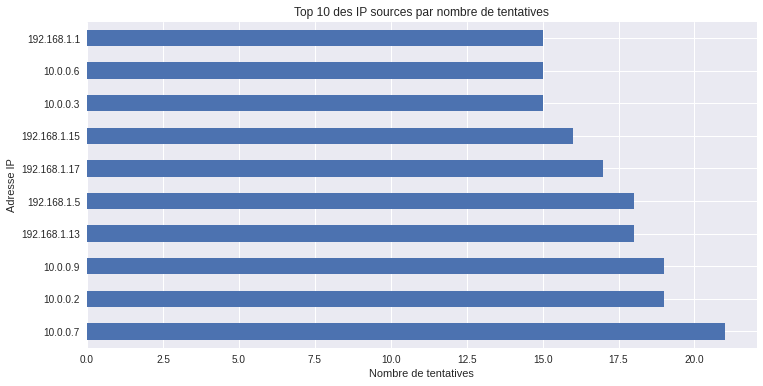


IP suspectes (nombreuses tentatives et faible taux de succès) :
              tentatives  taux_succes
ip_source                            
10.0.0.3              15        0.133
192.168.1.1           15        0.200
192.168.1.19          15        0.000


In [18]:
# Calcul du nombre de tentatives par IP
ip_attempts = df['ip_source'].value_counts()

# Création d'un graphique en barres horizontales pour les top 10 IP
plt.figure(figsize=(12, 6))
ip_attempts.head(10).plot(kind='barh')
plt.title('Top 10 des IP sources par nombre de tentatives')
plt.xlabel('Nombre de tentatives')
plt.ylabel('Adresse IP')
plt.grid(True)
plt.show()

# Analyse du taux de succès par IP
ip_success_rate = df.groupby('ip_source')['success'].agg([
    ('tentatives', 'count'),
    ('taux_succes', 'mean')
]).round(3)

# Identification des IP suspectes (beaucoup de tentatives, faible taux de succès)
ip_suspectes = ip_success_rate[
    (ip_success_rate['tentatives'] > ip_success_rate['tentatives'].mean()) & 
    (ip_success_rate['taux_succes'] < ip_success_rate['taux_succes'].mean())
]

print("\nIP suspectes (nombreuses tentatives et faible taux de succès) :")
print(ip_suspectes.sort_values('tentatives', ascending=False))

## Solution 3 : Identification des patterns temporels suspects

Pour détecter les patterns temporels suspects, nous allons :
1. Ajouter des colonnes temporelles pour l'analyse
2. Identifier les périodes avec un nombre anormal de tentatives
3. Visualiser la distribution temporelle

Périodes avec un nombre suspect de tentatives :
timestamp
2024-01-01 02:00:00    5
2024-01-01 02:30:00    4
2024-01-01 05:30:00    6
2024-01-01 08:30:00    3
2024-01-01 09:00:00    4
2024-01-01 10:00:00    6
2024-01-01 18:30:00    3
2024-01-01 19:00:00    5
2024-01-01 21:30:00    9
2024-01-02 00:30:00    9
2024-01-02 01:00:00    9
2024-01-02 01:30:00    4
2024-01-02 04:30:00    3
2024-01-02 06:00:00    7
2024-01-02 12:30:00    3
2024-01-02 13:00:00    7
2024-01-02 18:30:00    3
2024-01-02 19:00:00    7
2024-01-02 23:30:00    3
2024-01-03 05:00:00    6
2024-01-03 05:30:00    8
2024-01-03 06:00:00    9
2024-01-03 10:00:00    7
2024-01-03 12:30:00    7
2024-01-03 14:30:00    3
2024-01-03 15:30:00    4
2024-01-03 17:30:00    8
2024-01-03 18:00:00    8
2024-01-03 20:00:00    6
2024-01-03 22:30:00    8
2024-01-04 01:00:00    8
2024-01-04 02:00:00    3
2024-01-04 06:00:00    8
2024-01-04 08:00:00    8
2024-01-04 13:30:00    7
2024-01-04 15:30:00    4
2024-01-04 20:00:00    3
2024-01-04 20:30:

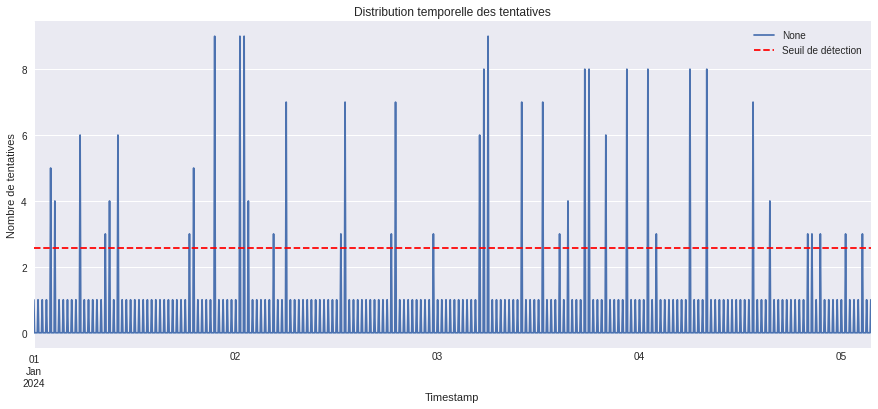

In [19]:
# Ajout de colonnes temporelles pour l'analyse
df['minute'] = df['timestamp'].dt.minute
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date

# Détection des rafales (nombreuses tentatives dans un court intervalle)
interval_counts = df.resample('5T', on='timestamp').size()

# Calcul du seuil pour les rafales (moyenne + 2 écarts-types)
seuil_rafale = interval_counts.mean() + 2 * interval_counts.std()

# Identification des périodes avec beaucoup de tentatives
periodes_suspectes = interval_counts[interval_counts > seuil_rafale]

print("Périodes avec un nombre suspect de tentatives :")
print(periodes_suspectes)

# Visualisation de la distribution temporelle
plt.figure(figsize=(15, 6))
interval_counts.plot()
plt.axhline(y=seuil_rafale, color='r', linestyle='--', label='Seuil de détection')
plt.title('Distribution temporelle des tentatives')
plt.xlabel('Timestamp')
plt.ylabel('Nombre de tentatives')
plt.legend()
plt.grid(True)
plt.show()

## Solution 4 : Indicateurs pour détecter une attaque par force brute

Création d'une fonction d'analyse complète pour détecter les attaques par force brute

Nombre d'incidents suspects détectés : 295

Top 10 des IP suspectes par nombre total de tentatives :
   ip_source          intervalle  nb_tentatives  taux_echec  total_tentatives
83  10.0.0.7 2024-01-01 09:04:00              1         1.0                21
90  10.0.0.7 2024-01-02 14:00:00              1         1.0                21
98  10.0.0.7 2024-01-04 23:00:00              1         1.0                21
84  10.0.0.7 2024-01-01 12:30:00              1         1.0                21
95  10.0.0.7 2024-01-04 14:30:00              1         1.0                21
93  10.0.0.7 2024-01-04 08:04:00              1         1.0                21
92  10.0.0.7 2024-01-03 14:30:00              2         1.0                21
91  10.0.0.7 2024-01-03 05:03:00              1         1.0                21
97  10.0.0.7 2024-01-04 20:02:00              1         1.0                21
88  10.0.0.7 2024-01-02 13:02:00              1         1.0                21


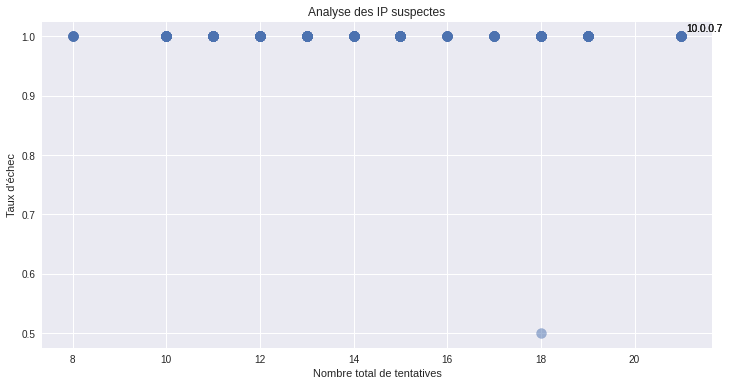

In [24]:
def analyser_force_brute(df, intervalle_minutes=1, seuil_tentatives=1, seuil_taux_echec=0.5):
    """Analyse les signes d'attaque par force brute
    
    Args:
        df: DataFrame contenant les logs
        intervalle_minutes: Fenêtre de temps pour l'analyse (réduit à 1 minute)
        seuil_tentatives: Nombre minimum de tentatives (ajusté à 1)
        seuil_taux_echec: Taux d'échec minimum (50%)
    """
    # Groupement par IP et intervalle de temps
    df['intervalle'] = df['timestamp'].dt.floor(f'{intervalle_minutes}min')
    
    # Analyse par IP et par intervalle
    analyse = df.groupby(['ip_source', 'intervalle']).agg({
        'success': ['count', lambda x: (x==0).mean()]
    }).reset_index()
    
    analyse.columns = ['ip_source', 'intervalle', 'nb_tentatives', 'taux_echec']
    
    # Comptons aussi le nombre total de tentatives par IP
    total_par_ip = df.groupby('ip_source').size().reset_index(name='total_tentatives')
    analyse = analyse.merge(total_par_ip, on='ip_source')
    
    # Identification des comportements suspects
    suspects = analyse[
        (analyse['nb_tentatives'] >= seuil_tentatives) &
        (analyse['taux_echec'] >= seuil_taux_echec) &
        (analyse['total_tentatives'] >= 3)  # Au moins 3 tentatives au total
    ]
    
    return suspects

# Test avec les nouveaux critères
suspects = analyser_force_brute(df)
print(f"Nombre d'incidents suspects détectés : {len(suspects)}")

if len(suspects) > 0:
    print("\nTop 10 des IP suspectes par nombre total de tentatives :")
    print(suspects.sort_values('total_tentatives', ascending=False)[
        ['ip_source', 'intervalle', 'nb_tentatives', 'taux_echec', 'total_tentatives']
    ].head(10))
    
    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.scatter(suspects['total_tentatives'], suspects['taux_echec'],
               alpha=0.5, s=100)
    plt.title('Analyse des IP suspectes')
    plt.xlabel('Nombre total de tentatives')
    plt.ylabel('Taux d\'échec')
    plt.grid(True)
    
    # Annotation des points les plus suspects
    top_suspects = suspects.nlargest(3, 'total_tentatives')
    for _, suspect in top_suspects.iterrows():
        plt.annotate(suspect['ip_source'], 
                    (suspect['total_tentatives'], suspect['taux_echec']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.show()

=== Rapport d'analyse des tentatives suspectes ===

Nombre d'IP suspectes détectées : 28

Détail des IP suspectes :
       ip_source  total_tentatives  taux_echec  nb_users  temps_min
6       10.0.0.7                21    0.761905         5        4.0
8       10.0.0.9                19    0.684211         5       52.0
1       10.0.0.2                19    0.684211         4     1524.0
23   192.168.1.5                18    0.777778         5     1563.0
13  192.168.1.13                18    0.777778         5        4.0
17  192.168.1.17                17    0.764706         5       69.0
15  192.168.1.15                16    0.562500         5       55.0
19  192.168.1.19                15    1.000000         5     1511.0
2       10.0.0.3                15    0.866667         5     1800.0
5       10.0.0.6                15    0.733333         5     1591.0
9    192.168.1.1                15    0.800000         5     1625.0
24   192.168.1.6                14    0.642857         5       28.0


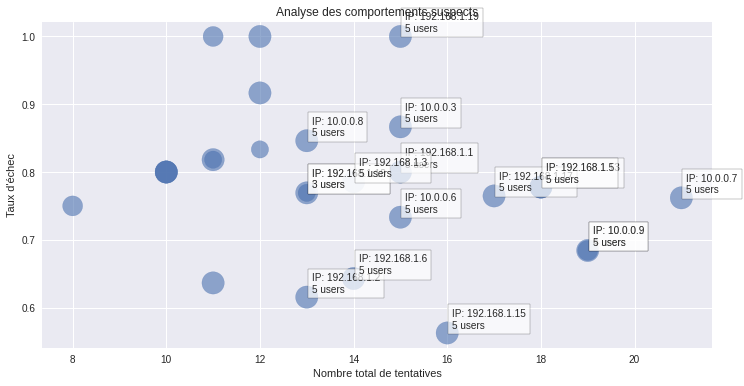


Statistiques des comportements suspects :
- Moyenne des tentatives : 13.8
- Moyenne du taux d'échec : 78.6%
- Nombre moyen d'utilisateurs testés : 4.7


In [25]:
def analyser_force_brute(df):
    """Analyse les signes d'attaque par force brute avec une approche plus sophistiquée"""
    
    # 1. Analyse temporelle : recherche de rafales
    df['intervalle'] = df['timestamp'].dt.floor('1min')
    
    # Calcul des métriques par IP
    analyse_ip = df.groupby('ip_source').agg({
        'success': ['count', lambda x: (x==0).mean()],  # nombre total et taux d'échec
        'username': 'nunique',  # nombre d'utilisateurs différents testés
        'timestamp': lambda x: x.diff().min().total_seconds()  # temps minimum entre deux tentatives
    }).reset_index()
    
    analyse_ip.columns = ['ip_source', 'total_tentatives', 'taux_echec', 'nb_users', 'temps_min']
    
    # Définition des critères de suspicion
    suspects = analyse_ip[
        (analyse_ip['total_tentatives'] >= 5) &  # Au moins 5 tentatives au total
        (
            # Soit beaucoup de tentatives avec un haut taux d'échec
            ((analyse_ip['total_tentatives'] >= 10) & (analyse_ip['taux_echec'] >= 0.8)) |
            # Soit des tentatives très rapprochées
            (analyse_ip['temps_min'] < 60) |  # Moins d'une minute entre tentatives
            # Soit test de plusieurs utilisateurs différents
            (analyse_ip['nb_users'] >= 3)
        )
    ]
    
    return suspects

# Application de l'analyse
suspects = analyser_force_brute(df)
print("=== Rapport d'analyse des tentatives suspectes ===\n")
print(f"Nombre d'IP suspectes détectées : {len(suspects)}")

if len(suspects) > 0:
    print("\nDétail des IP suspectes :")
    print(suspects.sort_values('total_tentatives', ascending=False))
    
    # Visualisation améliorée
    plt.figure(figsize=(12, 6))
    plt.scatter(suspects['total_tentatives'], suspects['taux_echec'],
               s=suspects['nb_users']*100,  # Taille des points proportionnelle au nombre d'utilisateurs
               alpha=0.6)
    
    plt.title('Analyse des comportements suspects')
    plt.xlabel('Nombre total de tentatives')
    plt.ylabel('Taux d\'échec')
    
    # Ajout de labels pour les cas les plus suspects
    for idx, row in suspects.iterrows():
        if row['total_tentatives'] >= suspects['total_tentatives'].median():
            plt.annotate(f"IP: {row['ip_source']}\n{row['nb_users']} users", 
                        (row['total_tentatives'], row['taux_echec']),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', alpha=0.7))
    
    plt.grid(True)
    plt.show()
    
    # Statistiques additionnelles
    print("\nStatistiques des comportements suspects :")
    print(f"- Moyenne des tentatives : {suspects['total_tentatives'].mean():.1f}")
    print(f"- Moyenne du taux d'échec : {suspects['taux_echec'].mean():.1%}")
    print(f"- Nombre moyen d'utilisateurs testés : {suspects['nb_users'].mean():.1f}")